In [1]:
from datasets import load_dataset
from io import BytesIO
import torch
import torchaudio
from spauq.core.metrics import spauq_eval
import zlib
import numpy as np
from dance.audio import RateDistortionAutoEncoder
from transformers import EncodecModel, AutoProcessor

/home/dgj335/.local/lib/python3.10/site-packages/beartype/_util/error/utilerrwarn.py:67: BeartypeModuleUnimportableWarning: Ignoring module "onnx" importation exception:
    ImportError: cannot import name 'builder' from 'google.protobuf.internal' (/home/dgj335/.local/lib/python3.10/site-packages/google/protobuf/internal/__init__.py)
  warn(message, cls)
/home/dgj335/.local/lib/python3.10/site-packages/beartype/_util/error/utilerrwarn.py:67: BeartypeModuleUnimportableWarning: Ignoring module "onnx" importation exception:
    ImportError: cannot import name 'builder' from 'google.protobuf.internal' (/home/dgj335/.local/lib/python3.10/site-packages/google/protobuf/internal/__init__.py)
  warn(message, cls)
/home/dgj335/.local/lib/python3.10/site-packages/beartype/_util/error/utilerrwarn.py:67: BeartypeModuleUnimportableWarning: Ignoring module "onnx" importation exception:
    ImportError: cannot import name 'builder' from 'google.protobuf.internal' (/home/dgj335/.local/lib/python3.10/si

In [2]:
dataset = load_dataset("danjacobellis/aria_ea_audio_preprocessed",split='validation').with_format("torch")

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

In [3]:
encodec_model = EncodecModel.from_pretrained("facebook/encodec_48khz")
encodec_processor = AutoProcessor.from_pretrained("facebook/encodec_48khz")

/home/dgj335/.local/lib/python3.10/site-packages/transformers/models/encodec/modeling_encodec.py:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [4]:
sum(p.numel() for p in encodec_model.encoder.parameters())

7428336

In [5]:
def encodec48(sample):
    fs=48000
    audio = sample['audio'].permute(1,0)
    reference = []
    recovered = []
    size_bytes = []
    for c in range(0,7,2):
        channels = audio[c:c+2]
        if channels.shape[0] != 2:
            channels = torch.cat([channels,channels])
        with torch.no_grad():
            inputs = encodec_processor(raw_audio=channels, sampling_rate=fs, return_tensors='pt')
            encoder_outputs = encodec_model.encode(inputs["input_values"], inputs["padding_mask"])
            size_bytes.append(6.0*10.0*torch.tensor(encoder_outputs.audio_codes.shape).prod().item()/8)
            audio_values = encodec_model.decode(encoder_outputs.audio_codes, encoder_outputs.audio_scales, inputs["padding_mask"])[0]
            audio_values = encodec_model(inputs["input_values"], inputs["padding_mask"]).audio_values
            reference.append(inputs['input_values'][0].detach())
            recovered.append(audio_values[0].detach())
    reference = torch.cat(reference)[0:7]
    recovered = torch.cat(recovered)[0:7]
    eval_output = spauq_eval(reference=reference,estimate=recovered,fs=fs)
    sample['encodec48_SSR'] = eval_output['SSR']
    sample['encodec48_SRR'] = eval_output['SRR']
    sample['encodec48_cr'] = 3*audio.numel()/sum(size_bytes) # 24 bit audio
    sample['encodec48_cr'] = (8/7)*sample['encodec48_cr'] # only 7 channels
    return sample

In [6]:
dataset = dataset.map(encodec48,writer_batch_size=100)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/home/dgj335/.local/lib/python3.10/site-packages/spauq/core/preprocessing.py:325: UserWarning: No forgive_mode specified, defaulting to `none`
  warnings.warn(


In [7]:
def mp3_q9_stereo(sample):
    fs = 48000
    audio = sample['audio'].permute(1, 0)
    config = torchaudio.io.CodecConfig(qscale=9)
    size_bytes = []
    recovered = []
    for c in range(0, 7, 2):
        channels = audio[c:c+2]
        if channels.shape[0] != 2:
            channels = torch.cat([channels,channels])
        
        with BytesIO() as f:
            torchaudio.save(f, channels, format="mp3", sample_rate=fs, compression=config)
            size_bytes.append(len(f.getvalue()))
            f.seek(0)
            recovered_channels, _ = torchaudio.load(f, format="mp3")
            recovered.append(recovered_channels)
    recovered = torch.cat(recovered, dim=0)[0:7]
    eval_output = spauq_eval(reference=audio, estimate=recovered, fs=fs)
    sample['mp3_q9_stereo_SSR'] = eval_output['SSR']
    sample['mp3_q9_stereo_SRR'] = eval_output['SRR']
    sample['mp3_q9_stereo_cr'] = 3 * audio.numel() / sum(size_bytes)
    sample['mp3_q9_stereo_cr'] = (8/7)*sample['mp3_q9_stereo_cr']
    return sample

In [8]:
dataset = dataset.map(mp3_q9_stereo,writer_batch_size=100)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [4]:
device = "cuda"
dance1_model = RateDistortionAutoEncoder()
checkpoint = torch.load("dance/audio_stage1_20e.pth")
dance1_model.load_state_dict(checkpoint['model_state_dict'])
dance1_model = dance1_model.to(device)

In [3]:
sum(p.numel() for p in dance1_model.encode.parameters())

331264

In [10]:
def dance1(sample):
    fs=48000
    audio = sample['audio'].permute(1,0)
    with torch.no_grad():
        compressed = dance1_model.encode(audio.unsqueeze(0).cuda()).round().to(torch.int8).cpu().numpy()
        original_shape = compressed.shape
        compressed = zlib.compress(compressed.tobytes(),level=9)
        size_bytes = len(compressed)
        recovered = zlib.decompress(compressed)
        recovered = np.frombuffer(recovered, dtype=np.int8)
        recovered = recovered.reshape(original_shape)
        recovered = torch.tensor(recovered).to(torch.float).cuda()
        recovered = dance1_model.decode(recovered).cpu()[0]
        eval_output = spauq_eval(reference=audio,estimate=recovered,fs=fs)
        sample['dance1_SSR'] = eval_output['SSR']
        sample['dance1_SRR'] = eval_output['SRR']
        sample['dance1_cr'] = 3*audio.numel()/size_bytes# 24 bit audio
        return sample

In [11]:
dataset = dataset.map(dance1,writer_batch_size=100)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [12]:
metrics = dataset.remove_columns(['audio','seq_name'])

In [13]:
for m in metrics.features:
    print(f"{m}: {metrics[m].median()} (median)")

encodec48_SSR: 1.974507451057434 (median)
encodec48_SRR: -10.795352935791016 (median)
encodec48_cr: 114.28571319580078 (median)
mp3_q9_stereo_SSR: 18.81805419921875 (median)
mp3_q9_stereo_SRR: 7.719813823699951 (median)
mp3_q9_stereo_cr: 31.307069778442383 (median)
dance1_SSR: 13.204813003540039 (median)
dance1_SRR: 5.730511665344238 (median)
dance1_cr: 66.89034271240234 (median)


In [14]:
for m in metrics.features:
    print(f"{m}: {metrics[m].mean()} (mean)")

encodec48_SSR: 2.7963006496429443 (mean)
encodec48_SRR: -11.709240913391113 (mean)
encodec48_cr: 114.28571319580078 (mean)
mp3_q9_stereo_SSR: 19.074310302734375 (mean)
mp3_q9_stereo_SRR: 7.163491249084473 (mean)
mp3_q9_stereo_cr: 31.554594039916992 (mean)
dance1_SSR: 13.64505386352539 (mean)
dance1_SRR: 2.5243210792541504 (mean)
dance1_cr: 601.7503662109375 (mean)


# Visual Comparison

In [78]:
import matplotlib.pyplot as plt

In [79]:
test_sample = dataset[10]['audio'].unsqueeze(0)
test_input = test_sample.permute(0,2,1).to("cuda")
orig = test_sample[0,0:1000,[0,6]]

In [80]:
test_input.shape

torch.Size([1, 7, 300000])

In [81]:
def encodec48_test(test_input):
    fs=48000
    audio = test_input[0].cpu()
    reference = []
    recovered = []
    size_bytes = []
    for c in range(0,7,2):
        channels = audio[c:c+2]
        if channels.shape[0] != 2:
            channels = torch.cat([channels,channels])
        with torch.no_grad():
            inputs = encodec_processor(raw_audio=channels, sampling_rate=fs, return_tensors='pt')
            encoder_outputs = encodec_model.encode(inputs["input_values"], inputs["padding_mask"])
            size_bytes.append(6.0*10.0*torch.tensor(encoder_outputs.audio_codes.shape).prod().item()/8)
            audio_values = encodec_model.decode(encoder_outputs.audio_codes, encoder_outputs.audio_scales, inputs["padding_mask"])[0]
            audio_values = encodec_model(inputs["input_values"], inputs["padding_mask"]).audio_values
            reference.append(inputs['input_values'][0].detach())
            recovered.append(audio_values[0].detach())
    reference = torch.cat(reference)[0:7]
    recovered = torch.cat(recovered)[0:7]
    return recovered.permute(1,0)

In [82]:
rec = encodec48_test(test_input)
encodec = rec[0:1000,[0,6]]

In [83]:
def dance1_test(test_input):
    fs=48000
    audio = test_input
    with torch.no_grad():
        compressed = dance1_model.encode(audio.cuda()).round().to(torch.int8).cpu().numpy()
        original_shape = compressed.shape
        compressed = zlib.compress(compressed.tobytes(),level=9)
        size_bytes = len(compressed)
        recovered = zlib.decompress(compressed)
        recovered = np.frombuffer(recovered, dtype=np.int8)
        recovered = recovered.reshape(original_shape)
        recovered = torch.tensor(recovered).to(torch.float).cuda()
        recovered = dance1_model.decode(recovered).cpu()[0]
        return recovered.permute(1,0)

In [84]:
rec = dance1_test(test_input)
dance = rec[0:1000,[0,6]]

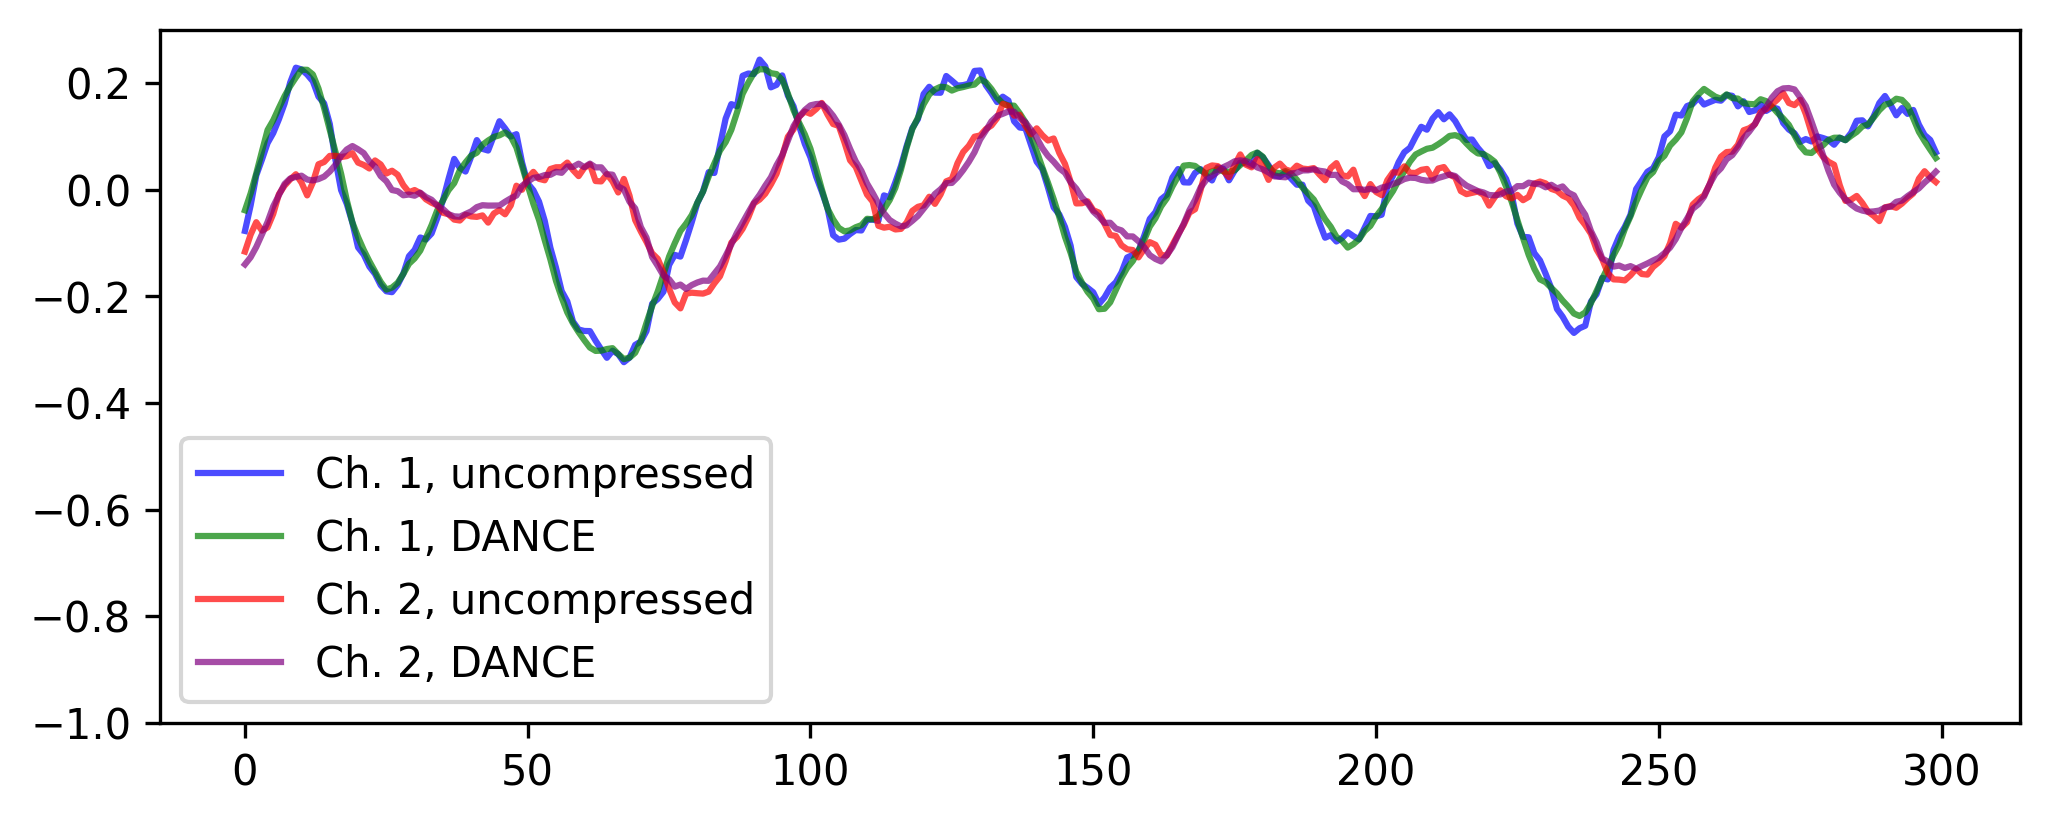

In [85]:
ind1=400
ind2=700
plt.figure(figsize=(8,3),dpi=300)
plt.plot( orig[ind1:ind2,0], c='blue',   alpha=0.7, label='Ch. 1, uncompressed')
plt.plot(dance[ind1:ind2,0], c='green',  alpha=0.7, label='Ch. 1, DANCE')
plt.plot( orig[ind1:ind2,1], c='red',    alpha=0.7, label='Ch. 2, uncompressed')
plt.plot(dance[ind1:ind2,1], c='purple', alpha=0.7, label='Ch. 2, DANCE')
plt.ylim([-1,0.3])
plt.legend()

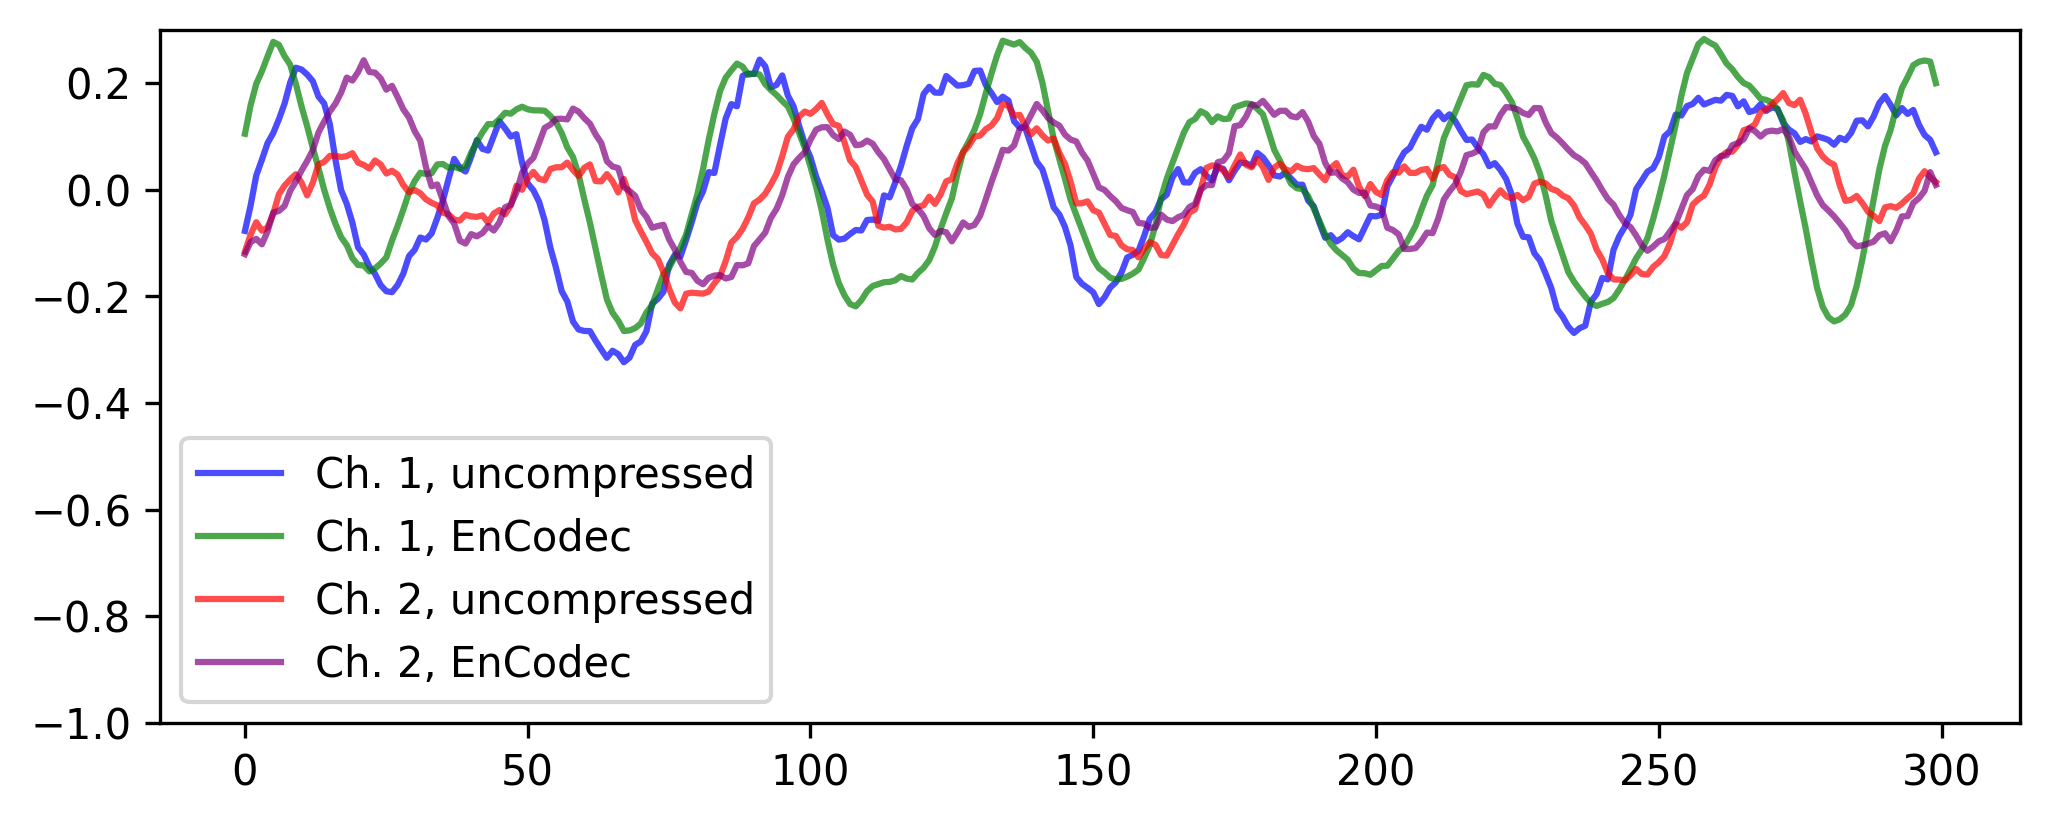

In [86]:
ind1=400
ind2=700
plt.figure(figsize=(8,3),dpi=300)
plt.plot(   orig[ind1:ind2,0], c='blue',   alpha=0.7, label='Ch. 1, uncompressed')
plt.plot(encodec[ind1:ind2,0], c='green',  alpha=0.7, label='Ch. 1, EnCodec')
plt.plot(   orig[ind1:ind2,1], c='red',    alpha=0.7, label='Ch. 2, uncompressed')
plt.plot(encodec[ind1:ind2,1], c='purple', alpha=0.7, label='Ch. 2, EnCodec')
plt.ylim([-1,0.3])
plt.legend()